In [65]:
'''
Import the packages needed for classification
'''
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
import sklearn.metrics as metrics
import cv2
from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.feature import hog
from skimage import exposure
plt.close()

In [66]:
'''
Set directory parameters
'''
# Set the directories for the data and the CSV files that contain ids/labels
dir_train_images  = '../data/training/'
dir_test_images   = '../data/testing/'
dir_train_labels  = '../data/labels_training.csv'
dir_test_ids      = '../data/sample_submission.csv'

In [67]:
def load_data(dir_data, dir_labels, training = True):
    '''
    Load each of the image files into memory 

    While this is feasible with a smaller dataset, for larger datasets,
    not all the images would be able to be loaded into memory

    When training = True, the labels are also loaded
    '''
    labels_pd = pd.read_csv(dir_labels)
    ids       = labels_pd.id.values
    data      = []
    for identifier in ids:
        fname     = dir_data + identifier.astype(str) + '.tif'
        image     = mpl.image.imread(fname)
        data.append(image)
    data = np.array(data) # Convert to Numpy array
    if training:
        labels = labels_pd.label.values
        return data, labels
    else:
        return data, ids

In [134]:
def preprocess_and_extract_features(data, prc):
    '''Preprocess data and extract features
    
    Preprocess: normalize, scale, repair
    Extract features: transformations and dimensionality reduction
    
    data: X matrix of images/features
    prc: string for selected features extraction process -> 'HOG', 'simple'
    '''
    if prc == 'colors':
        # Here, we do something trivially simple: we take the average of the RGB
        # values to produce a grey image, transform that into a vector, then
        # extract the mean and standard deviation as features.
               
        color_lo = np.asarray([0, 0, 110])
        color_hi = np.asarray([55, 87, 187])
        new_data = []
        
        for img in data:
            img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
            mask = cv2.inRange(img_hsv, color_lo, color_hi)
            mask[mask != 0] = 1 #keep colors
            mask = np.expand_dims(mask, axis = 2)
            mask = np.append(np.append(mask, mask, axis = 2), mask, axis = 2)
            feature = img * mask
            
            if np.count_nonzero(feature) != 0: 
                feature = np.sum(np.sum(feature, axis = 0), axis = 0) / np.count_nonzero(feature)
            else:
                feature = [255, 255, 255]

            new_data.append(feature)
        
        features = np.array(new_data)

        return features
    
    elif prc == 'HOG':
        #data = np.array([resize(image, (128, 64)) for image in data])
        
        # Make the image grayscale
        #data = np.mean(data, axis = 3)
        
        get_hog = lambda X: hog(X, orientations = 9, pixels_per_cell = (16, 16),
                                cells_per_block = (4, 4), visualize = False, multichannel = True)
        features = np.array([get_hog(image) for image in data])

        return features

In [135]:
def set_classifier(clf):
    '''Shared function to select the classifier for both performance evaluation
    and testing
    '''
    if clf == 'knn':
        return KNeighborsClassifier(n_neighbors = 7)
    elif clf == 'logistic':
        return LogisticRegression(solver = 'liblinear')

In [136]:
def cv_performance_assessment(X, y, k, clf, prc):
    '''Cross validated performance assessment
    
    X   = training data
    y   = training labels
    k   = number of folds for cross validation
    clf = classifier to use
    prc = feature extraction process
    
    Divide the training data into k folds of training and validation data. 
    For each fold the classifier will be trained on the training data and
    tested on the validation data. The classifier prediction scores are 
    aggregated and output
    '''
    # Establish the k folds
    prediction_scores = np.empty(y.shape[0], dtype = 'object')
    kf = StratifiedKFold(n_splits = k, shuffle = True)
    for train_index, val_index in kf.split(X, y):
        # Extract the training and validation data for this fold
        X_train_l, X_val = X[train_index], X[val_index]
        y_train_l        = y[train_index]
        
        # Train the classifier
        X_train_features = preprocess_and_extract_features(X_train_l, prc)
        clf              = clf.fit(X_train_features, y_train_l)
        
        # Test the classifier on the validation data for this fold
        X_val_features   = preprocess_and_extract_features(X_val, prc)
        cpred            = clf.predict_proba(X_val_features)
        
        # Save the predictions for this fold
        prediction_scores[val_index] = cpred[:, 1]
    return prediction_scores

In [137]:
def plot_roc(labels, prediction_scores):
    '''
    Function to plot ROC curve
    '''
    fpr, tpr, _   = metrics.roc_curve(labels, prediction_scores, pos_label = 1)
    auc           = metrics.roc_auc_score(labels, prediction_scores)
    legend_string = 'AUC = {:0.3f}'.format(auc)
   
    plt.plot([0, 1], [0, 1], '--', color = 'gray', label = 'Chance')
    plt.plot(fpr, tpr, label = legend_string)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid('on')
    plt.axis('square')
    plt.legend()
    plt.tight_layout()

In [138]:
'''
Loading data
'''
X_train, y_train = load_data(dir_train_images, dir_train_labels)
X_test, ids_test = load_data(dir_test_images, dir_test_ids, training = False)

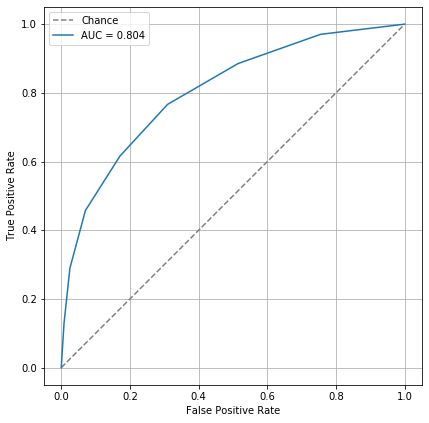

In [139]:
'''
Sample script for cross validated performance
'''
# Set parameters for the analysis
num_training_folds = 10

# Choose which classifier to use
clf = set_classifier('knn')

# Choose which feature extraction process to use: 'colors', 'HOG'
prc = 'HOG'

# Perform cross validated performance assessment
prediction_scores1 = cv_performance_assessment(X_train, y_train, num_training_folds, clf, prc)

# Compute and plot the ROC curves
plt.figure(figsize = (6, 6))
plot_roc(y_train, prediction_scores1)

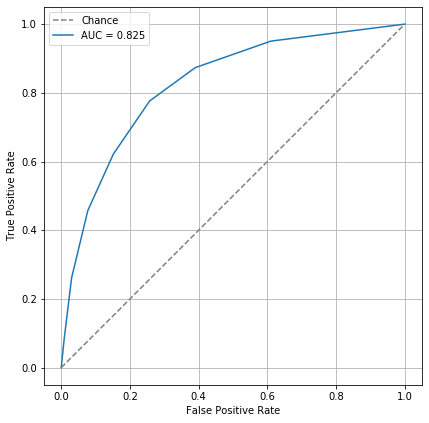

In [145]:
'''
Sample script for cross validated performance
'''
# Set parameters for the analysis
num_training_folds = 20

# Choose which classifier to use
clf = set_classifier('knn')

# Choose which feature extraction process to use: 'colors', 'HOG'
prc = 'colors'

# Perform cross validated performance assessment
prediction_scores2 = cv_performance_assessment(X_train, y_train, num_training_folds, clf, prc)

# Compute and plot the ROC curves
plt.figure(figsize = (6, 6))
plot_roc(y_train, prediction_scores2)

In [154]:
Z_train = np.stack((prediction_scores1, prediction_scores2), axis = -1)
clf3 = set_classifier('logistic')
clf3.fit(Z_train, y_train)

new_scores = clf3.predict_proba(Z_train)[:, 1]

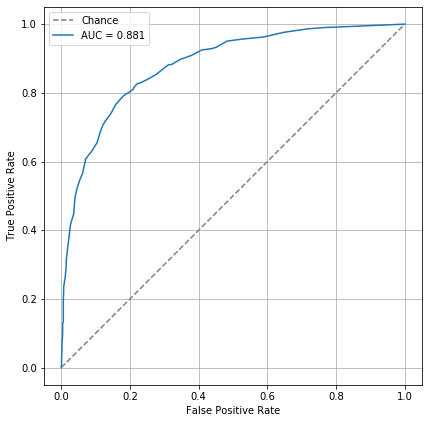

In [155]:

# Compute and plot the ROC curves
plt.figure(figsize = (6, 6))
plot_roc(y_train, new_scores)

In [158]:
'''
Sample script for producing a Kaggle submission
'''
produce_submission = True # Switch this to True when you're ready to create a submission for Kaggle

# Choose which classifier to use
clf = set_classifier('knn')

# Choose which feature extraction process to use: 'simple', 'HOG'
prc = 'HOG'

if produce_submission:
    # Load data, extract features, and train the classifier on the training data
    training_features = preprocess_and_extract_features(X_train, prc)
    clf.fit(training_features, y_train)

    # Load the test data and test the classifier
    test_features1  = preprocess_and_extract_features(X_test, prc)
    test_scores1    = clf.predict_proba(test_features1)[:,1]

    # Save the predictions to a CSV file for upload to Kaggle
    submission_file = pd.DataFrame({'id':    ids_test,
                                    'score': test_scores1})
    submission_file.to_csv('../submission/submissionHOG.csv',
                           columns = ['id', 'score'],
                           index = False)

In [159]:
'''
Sample script for producing a Kaggle submission
'''
produce_submission = True # Switch this to True when you're ready to create a submission for Kaggle

# Choose which classifier to use
clf2 = set_classifier('knn')

# Choose which feature extraction process to use: 'simple', 'HOG'
prc = 'colors'

if produce_submission:
    # Load data, extract features, and train the classifier on the training data
    training_features = preprocess_and_extract_features(X_train, prc)
    clf2.fit(training_features, y_train)

    # Load the test data and test the classifier
    test_features2  = preprocess_and_extract_features(X_test, prc)
    test_scores2    = clf2.predict_proba(test_features2)[:,1]

    # Save the predictions to a CSV file for upload to Kaggle
    submission_file = pd.DataFrame({'id':    ids_test,
                                    'score': test_scores2})
    submission_file.to_csv('../submission/submissionCOLORS.csv',
                           columns = ['id', 'score'],
                           index = False)

In [160]:
Z_test = np.stack((test_scores1, test_scores2), axis = -1)
new_score_test = clf3.predict_proba(Z_test)[:, 1]
new_score_test

array([0.11812063, 0.12332261, 0.82564717, 0.04737905, 0.50501004,
       0.11812063, 0.50501004, 0.02941538, 0.11812063, 0.39111508,
       0.11812063, 0.3872313 , 0.18019826, 0.82089321, 0.04737905,
       0.07546005, 0.04812192, 0.37566743, 0.73316277, 0.02941538,
       0.82564717, 0.02941538, 0.07546005, 0.02941538, 0.39111508,
       0.27150799, 0.37950705, 0.11812063, 0.88763104, 0.07546005,
       0.18019826, 0.07546005, 0.18262442, 0.62223535, 0.73316277,
       0.26828859, 0.72995436, 0.04737905, 0.72995436, 0.7395064 ,
       0.95439754, 0.11812063, 0.62988482, 0.63746965, 0.1215671 ,
       0.50909367, 0.07777156, 0.04737905, 0.39111508, 0.63746965,
       0.63746965, 0.88599112, 0.07546005, 0.97215334, 0.18262442,
       0.02941538, 0.92838304, 0.02941538, 0.07546005, 0.11812063,
       0.95510336, 0.11983316, 0.02941538, 0.28131027, 0.74575151,
       0.07546005, 0.07777156, 0.11812063, 0.18507588, 0.07660781,
       0.04737905, 0.88433038, 0.18262442, 0.07777156, 0.63368

In [161]:
# Save the predictions to a CSV file for upload to Kaggle
submission_file = pd.DataFrame({'id':    ids_test,
                                'score': new_score_test})
submission_file.to_csv('../submission/submissionCOMBINED3.csv',
                       columns = ['id', 'score'],
                       index = False)

In [225]:
plt.figure(figsize = (4, 4))
img = X_train[8]   # you can read in images with opencv

<Figure size 288x288 with 0 Axes>

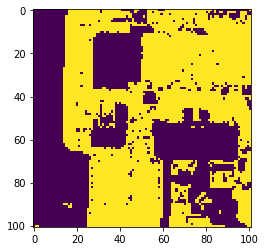

In [174]:
plt.figure(figsize = (4, 4))
#img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

hsv_color1 = np.asarray([30, 10, 60])
hsv_color2 = np.asarray([230, 255, 240])

mask = cv2.inRange(img_hsv, hsv_color1, hsv_color2)

plt.imshow(mask)

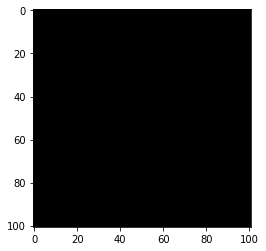

In [343]:
plt.figure(figsize = (4, 4))
img_hsv = cv2.cvtColor(X_train[8], cv2.COLOR_BGR2HSV)

hsv_color1 = np.asarray([0, 0, 0])
hsv_color2 = np.asarray([0, 0, 0])

mask = cv2.inRange(img_hsv, hsv_color1, hsv_color2)

plt.imshow(mask, cmap = 'gray')

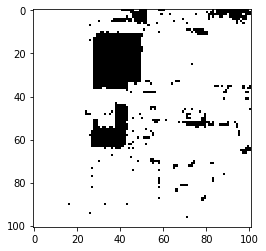

In [342]:
plt.figure(figsize = (4, 4))
img_hsv = cv2.cvtColor(X_train[8], cv2.COLOR_BGR2HSV)

hsv_color1 = np.asarray([30, 10, 60])
hsv_color2 = np.asarray([230, 255, 240])

mask = cv2.inRange(img_hsv, hsv_color1, hsv_color2)

plt.imshow(mask, cmap = 'gray')

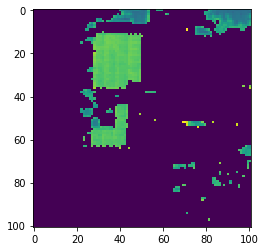

In [77]:
mask2 = np.copy(mask)
mask2[mask2 == 0] = 1
mask2[mask2 != 1] = 0
plt.imshow(np.mean(img, axis = 2) * mask2)



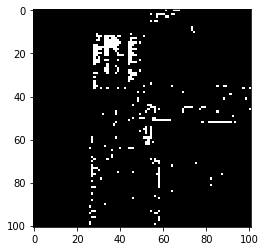

In [13]:
hsv_color1 = np.asarray([81, 99, 111])
hsv_color2 = np.asarray([120, 120, 150])

mask = cv2.inRange(img, hsv_color1, hsv_color2)

plt.imshow(mask, cmap = 'gray')

In [14]:
mask.shape

(101, 101)

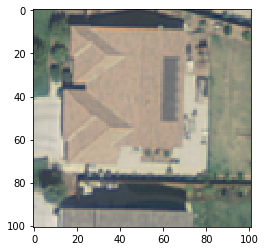

In [121]:
plt.figure(figsize = (4, 4))
plt.imshow(imgs_1[500])

In [10]:
imgs_0 = X_train[y_train == 0] # Not 3's
imgs_1 = X_train[y_train == 1] # 3's

sample_indices_0 = np.random.choice(imgs_0.shape[0], 10, replace = False)
sample_indices_1 = np.random.choice(imgs_1.shape[0], 10, replace = False)
sample_indices_0

array([  6, 501, 634, 832, 962,  12, 702, 728, 203, 707])

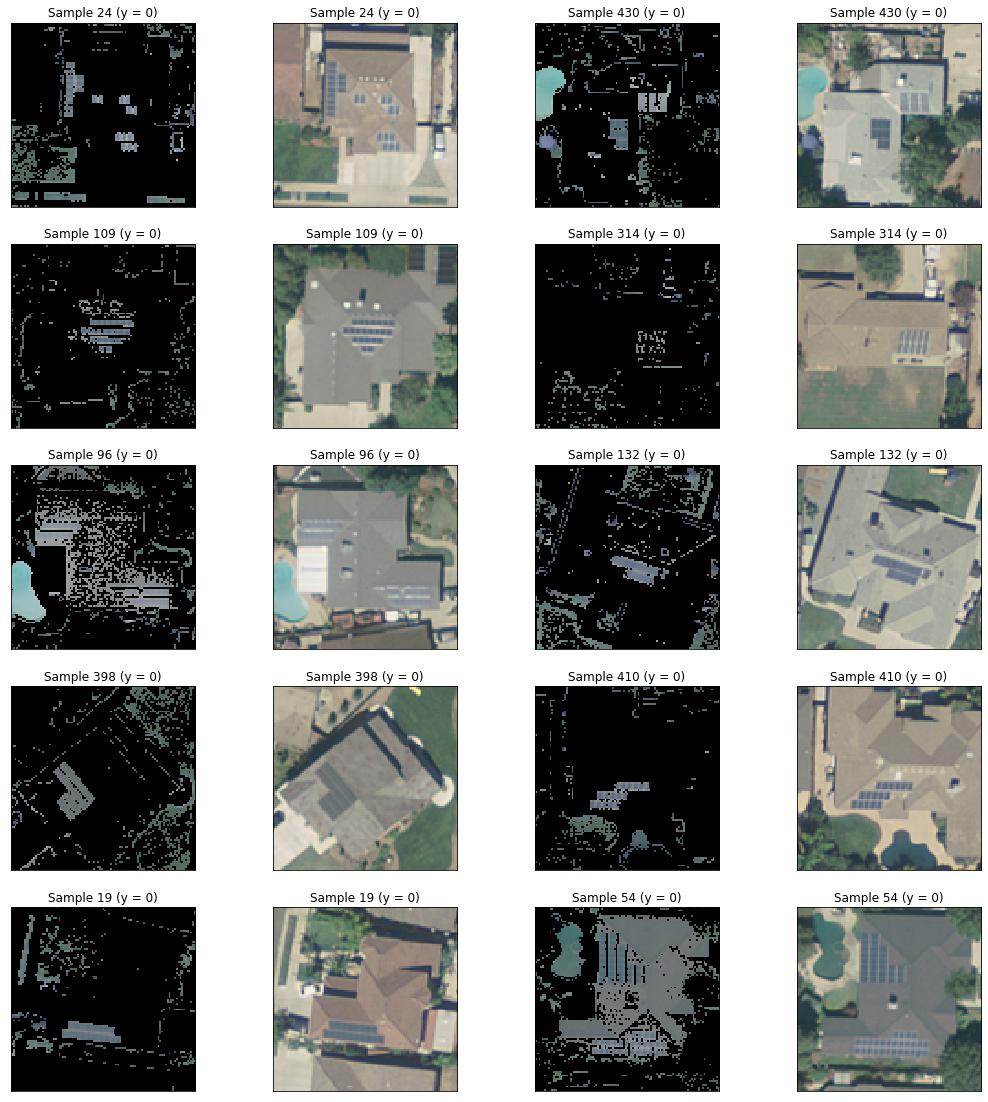

In [124]:
from pylab import rcParams

rcParams['figure.figsize'] = 18, 40
plt.figure()

#hsv_color1 = np.asarray([30, 10, 60])
#hsv_color2 = np.asarray([230, 255, 240])
hsv_color1 = np.asarray([0, 0, 100])
hsv_color2 = np.asarray([50, 100, 200])


for i in range(0, 20, 2):
    plt.subplot(10, 4, i + 1)
    img = imgs_1[sample_indices_1[int(i / 2)]]
    #img = cv2.addWeighted(img, alpha, np.zeros(img.shape, img.dtype), 0, beta)
    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(img_hsv, hsv_color1, hsv_color2)
    mask2 = np.copy(mask)
    #mask2[mask2 == 0] = 1 #filter out colors
    #mask2[mask2 != 1] = 0
    mask2[mask2 != 0] = 1 #keep colors
    mask2 = np.expand_dims(mask2, axis = 2)
    mask2 = np.append(np.append(mask2, mask2, axis = 2), mask2, axis = 2)
    plt.imshow(img * mask2)
    plt.title('Sample ' + str(sample_indices_1[int(i / 2)]) + ' (y = 0)')
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(10, 4, i + 2)
    plt.imshow(img)
    plt.title('Sample ' + str(sample_indices_1[int(i / 2)]) + ' (y = 0)')
    plt.xticks([])
    plt.yticks([])

In [240]:
prueba = np.expand_dims(mask2, axis = 2)

In [249]:
np.append(np.append(prueba, prueba, axis = 2), prueba, axis = 2)

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

In [259]:
plt.figure(figsize = (4, 4))
np.mean(np.mean(X_train[0], axis = 0), axis = 0)

array([157.97568866, 148.32918341, 134.09067738])

<Figure size 288x288 with 0 Axes>

[47.11897203 46.52199546 42.98740237]


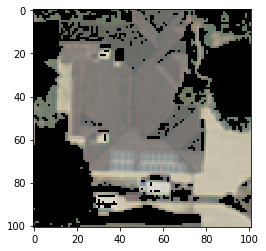

In [123]:
color_lo = np.asarray([100, 10, 60])
color_hi = np.asarray([230, 255, 240])

plt.figure(figsize = (4, 4))
img = X_train[589]
#img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
mask = cv2.inRange(img, color_lo, color_hi)
#mask[mask == 0]  = 1
mask[mask != 0]  = 1
mask = np.expand_dims(mask, axis = 2)
mask = np.append(np.append(mask, mask, axis = 2), mask, axis = 2)
features = img * mask
plt.imshow(features)
#features = np.mean(np.mean(features, axis = 0), axis = 0)
if np.count_nonzero(features) != 0: 
    features = np.sum(np.sum(features, axis = 0), axis = 0) / np.count_nonzero(features)
else:
    features = [0, 0, 0]
print(features)

In [117]:
def extract_colors(img, color_lo, color_hi):
    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(img_hsv, color_lo, color_hi)
    #mask[mask == 0]  = 1 #filter out
    #mask[mask != 1]  = 0
    mask[mask != 0] = 1 #keep colors
    mask = np.expand_dims(mask, axis = 2)
    mask = np.append(np.append(mask, mask, axis = 2), mask, axis = 2)
    features = img * mask
    #features = np.mean(np.mean(features, axis = 0), axis = 0)
    
    if np.count_nonzero(features) != 0: 
        features = np.sum(np.sum(features, axis = 0), axis = 0) / np.count_nonzero(features)
    else:
        features = [0, 0, 0]
    return features

In [125]:
aucs      = []
color_los = []
color_his = []
step      = 42

for r_lo in range(0, 1, 1):
    for r_hi in range(55, 66, 5):
        for g_lo in range(0, 1, 1):
            for g_hi in range(87, 98, 5):
                for b_lo in range(105, 116, 5):
                    for b_hi in range(187, 198, 5):
                        color_lo = np.asarray([r_lo, g_lo, b_lo])
                        color_hi = np.asarray([r_hi, g_hi, b_hi])
                        features = np.array([extract_colors(img, color_lo, color_hi) for img in X_train])
                        
                        knn = KNeighborsClassifier(n_neighbors = 7)
                        knn.fit(features, y_train)
                        scores = knn.predict_proba(features)[:, 1]
                        auc = metrics.roc_auc_score(y_train, scores)
                        
                        color_los.append((r_lo, g_lo, b_lo))
                        color_his.append((r_hi, g_hi, b_hi))
                        aucs.append(auc)

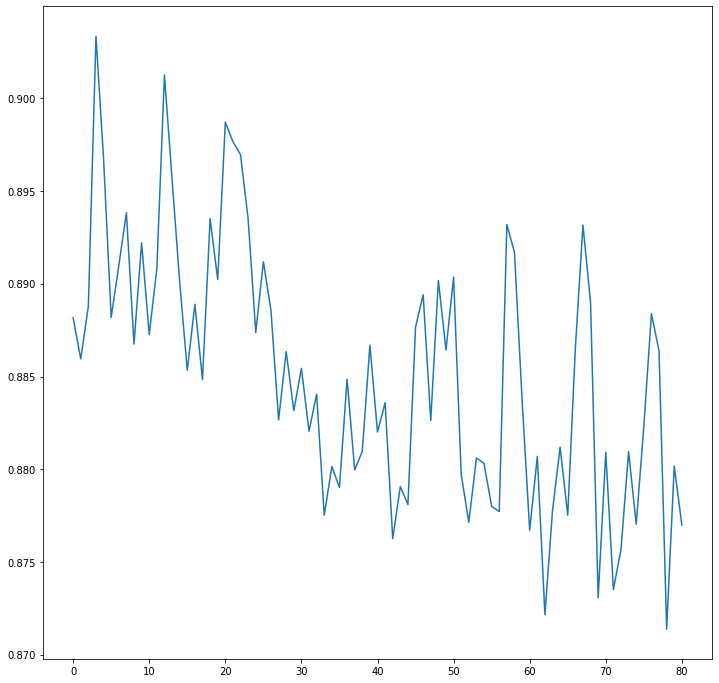

In [126]:
plt.figure(figsize = (12, 12))
plt.plot(range(len(aucs)), aucs)
i = 0
for x in range(0, 256, step):
    #plt.axvline(x = i, linestyle = '--', color = 'gray', alpha = 0.5)
    for y in range(x, 256, step):
        i += 1
    

In [128]:
color_los[aucs.index(max(aucs))], color_his[aucs.index(max(aucs))]

((0, 0, 110), (55, 87, 187))

In [485]:
aucs.index(max(aucs))

20

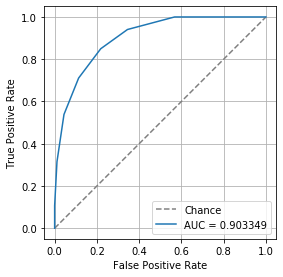

In [133]:
plt.figure(figsize = (4, 4))
color_lo = np.asarray([0, 0, 110])
color_hi = np.asarray([55, 87, 187])
#color_lo = np.asarray([42, 126, 168])
#color_hi = np.asarray([126, 210, 210])
features = np.array([extract_colors(img, color_lo, color_hi) for img in X_train])

clf = set_classifier('knn')
clf.fit(features, y_train)
scores = clf.predict_proba(features)[:, 1]

auc = metrics.roc_auc_score(y_train, scores)
fpr, tpr, _   = metrics.roc_curve(y_train, scores, pos_label = 1)
legend_string = 'AUC = {:0.6f}'.format(auc)

plt.plot([0, 1], [0, 1], '--', color = 'gray', label = 'Chance')
plt.plot(fpr, tpr, label = legend_string)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid('on')
plt.axis('square')
plt.legend()
plt.tight_layout()